In [1]:
%load_ext autoreload
%autoreload 2
import torch 
import os
import numpy as np
import scipy as sp
from scipy.signal import savgol_filter
import pandas as pd
from utils.misc import snv
import utils
from torch import nn
from torch.nn import functional as F
from torch import optim
from net.chemtools.PLS import PLS
from tensorflow.keras.utils import to_categorical  
from net.base_net import CuiNet , DeepSpectraCNN, ResNet18_1D , ViT_1D, FullyConvNet
from utils.testing import ccc,r2_score,RMSEP
import matplotlib.pyplot as plt
from utils.training import train
from utils.testing import test
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split


2024-09-05 11:30:34.709871: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
cal1 = pd.read_csv('data/dataset/Wheat_dt/DT_train-1.csv',header=None)
cal2 = pd.read_csv('data/dataset/Wheat_dt/DT_train-2.csv',header=None)
cal3 = pd.read_csv('data/dataset/Wheat_dt/DT_train-3.csv',header=None)
cal4 = pd.read_csv('data/dataset/Wheat_dt/DT_train-4.csv',header=None)
cal5 = pd.read_csv('data/dataset/Wheat_dt/DT_train-5.csv',header=None)
## validation
val1 = pd.read_csv('data/dataset/Wheat_dt/DT_val-1.csv',header=None)
val2 = pd.read_csv('data/dataset/Wheat_dt/DT_val-2.csv',header=None)
## test
pre1 = pd.read_csv('data/dataset/Wheat_dt/DT_test-1.csv',header=None)
pre2 = pd.read_csv('data/dataset/Wheat_dt/DT_test-2.csv',header=None)
pre3 = pd.read_csv('data/dataset/Wheat_dt/DT_test-3.csv',header=None)


In [7]:
## Concatenate input variables, X
cal_features = np.concatenate((cal1.iloc[:, 0:-1],cal2.iloc[:, 0:-1],cal3.iloc[:, 0:-1],cal4.iloc[:, 0:-1],cal5.iloc[:, 0:-1]),axis=0)
val_features = np.concatenate((val1.iloc[:, 0:-1],val2.iloc[:, 0:-1]),axis = 0)
pre_features = np.concatenate((pre1.iloc[:, 0:-1],pre2.iloc[:, 0:-1],pre3.iloc[:, 0:-1]),axis = 0)

## Concatenate the target variable or lables, Y
cal_labels = np.concatenate((cal1.iloc[:, -1],cal2.iloc[:, -1],cal3.iloc[:, -1],cal4.iloc[:, -1],cal5.iloc[:, -1]),axis = 0)
val_labels = np.concatenate((val1.iloc[:, -1],val2.iloc[:, -1]),axis=0)
pre_labels = np.concatenate((pre1.iloc[:, -1],pre2.iloc[:, -1],pre3.iloc[:, -1]),axis = 0)

## Settings for the smooth derivatives using a Savitsky-Golay filter
w = 13 ## Sav.Gol window size
p = 2  ## Sav.Gol polynomial degree

## Perform data augmentation in the feature space by combining different types of typical chemometric spectral pre-processings
## [spectra, SNV, 1st Deriv., 2nd Deriv., 1st Deriv. SNV, 2nd Deriv. SNV]
x_cal = np.concatenate((cal_features, snv(cal_features),savgol_filter(cal_features, w, polyorder = p, deriv=1),\
                                savgol_filter(cal_features, w, polyorder = p, deriv=2),savgol_filter(snv(cal_features), w, polyorder = p, deriv=1),\
                                savgol_filter(snv(cal_features), w, polyorder = p, deriv=2)),axis = 1)
x_val = np.concatenate((val_features, snv(val_features),savgol_filter(val_features, w, polyorder = p, deriv=1),\
                                savgol_filter(val_features, w, polyorder = p, deriv=2),savgol_filter(snv(val_features), w, polyorder = p, deriv=1),\
                                savgol_filter(snv(val_features), w, polyorder = p, deriv=2)),axis =1)
x_test= np.concatenate((pre_features, snv(pre_features),savgol_filter(pre_features, w, polyorder = p, deriv=1),\
                                savgol_filter(pre_features, w, polyorder = p, deriv=2),savgol_filter(snv(pre_features), w, polyorder = p, deriv=1),\
                                savgol_filter(snv(pre_features), w, polyorder = p, deriv=2)),axis =1)


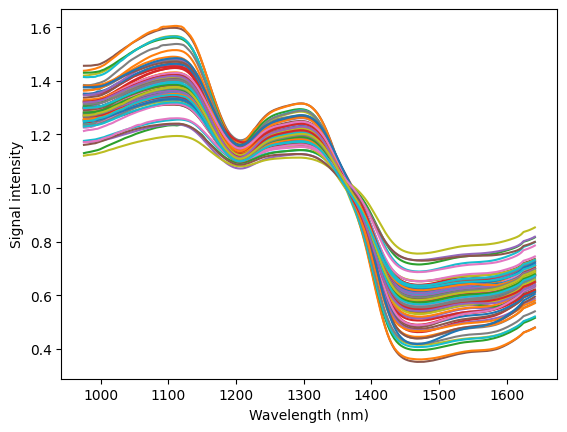

In [8]:
## Create wavelength x-scale by interpolating the range mentioned in the original wheat paper
delta_co = (1645-975)/200 # wavelenght step
# print(delta_co)
co=975+np.arange(200)*delta_co

plt.plot(co, cal_features[:100,:].T)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal intensity')
plt.show()

y_cal = np.eye(30)[cal_labels]
y_val = np.eye(30)[val_labels]
y_test = np.eye(30)[pre_labels]

In [9]:
## Concatenate input variables, X
# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

# Convert np.array to Dataloader 

cal = data_utils.TensorDataset(torch.Tensor(x_cal), torch.Tensor(y_cal))
cal_loader = data_utils.DataLoader(cal, batch_size=1024, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
val_loader = data_utils.DataLoader(val, batch_size=1024, shuffle=True)

test_dt = data_utils.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_loader = data_utils.DataLoader(test_dt, batch_size=1024, shuffle=True)


CuiNet(
  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=1196, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=30, bias=True)
)
Epoch 1/1000 | Train Losses: y 0: 0.8375 | Validation Losses: y 0: 0.5070| F1 Score: 0.03879166767001152
Epoch 2/1000 | Train Losses: y 0: 0.4193 | Validation Losses: y 0: 0.3056| F1 Score: 0.036916665732860565
Epoch 3/1000 | Train Losses: y 0: 0.2776 | Validation Losses: y 0: 0.2162| F1 Score: 0.04262499883770943
Epoch 4/1000 | Train Losses: y 0: 0.2163 | Validation Losses: y 0: 0.1792| F1 Score: 0.04308333247900009
Epoch 5/1000 | Train Losses: y 0: 0.1893 | Validation Losses: y 0: 0.1630| F1 Score: 0.04320833459496498
Epoch 6/1000 | Train Losses: y 0: 0.1758 | Validation Losses: y 0: 0.1550| F1 Score: 0.044458333402872086
Epoch 7/1000 | Train Losses: y 0: 0.1683 | Validation Losses

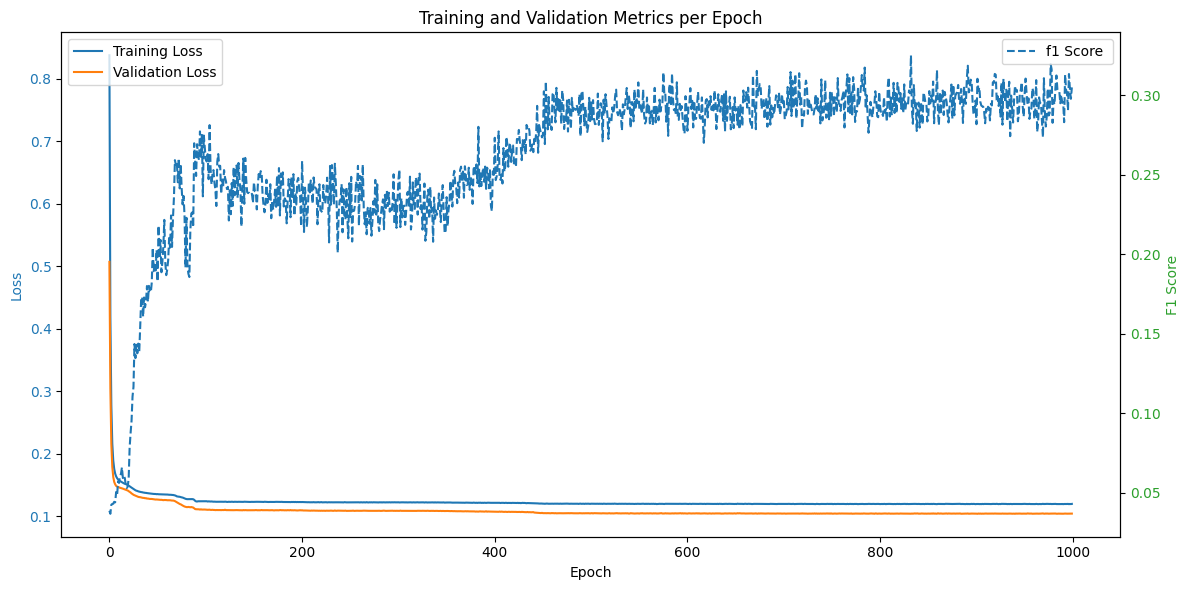

In [15]:
model_name ="_CuiNet_Wheat"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 1000
save_interval = 10
data_path ="/home/metz/deepchemometrics/Aioly/data/dataset/Wheat_dt/DT_test-1.csv"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = CuiNet(spec_dims, mean = mean,std = std, out_dims=30) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.BCEWithLogitsLoss(reduction='mean')
criterion_test = nn.BCEWithLogitsLoss(reduction='mean')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval, classification = True)

AttributeError: 'CrossEntropyLoss' object has no attribute 'name'

DeepSpectraCNN(
  (conv1): Conv1d(1, 8, kernel_size=(7,), stride=(3,), padding=(3,))
  (inception2): InceptionModule(
    (branch1): ConvBlock1D(
      (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
      (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (branch2): Sequential(
      (0): ConvBlock1D(
        (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
        (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): ConvBlock1D(
        (conv1d): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (branch3): Sequential(
      (0): ConvBlock1D(
        (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
        (batchnorm1d)

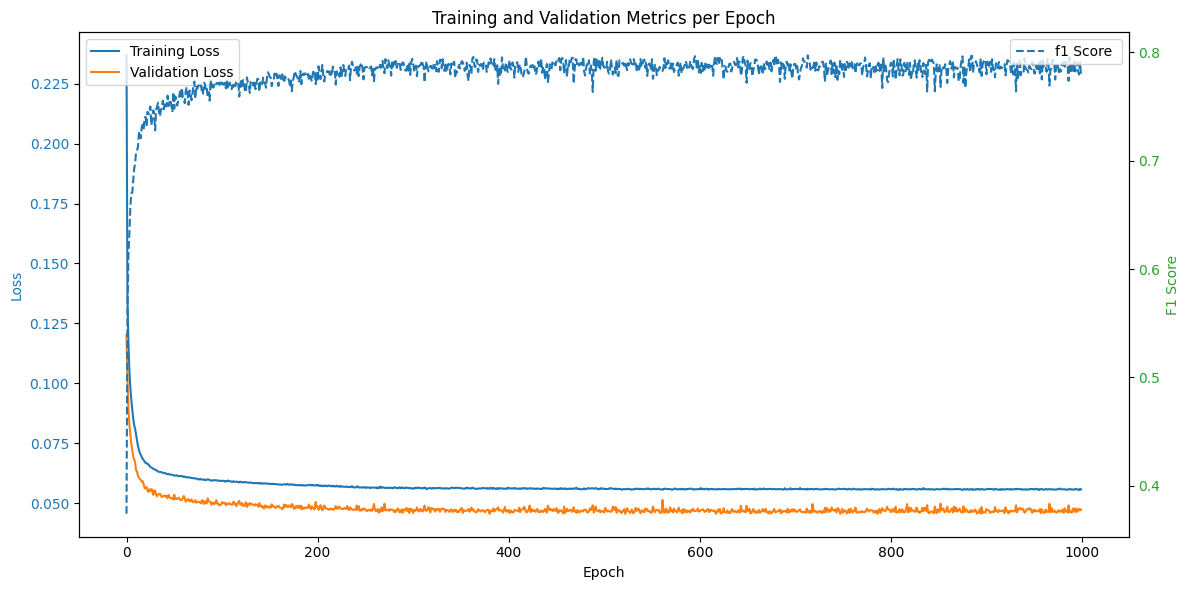

In [16]:
model_name ="_DeepSpectra_Wheat"  
spec_dims = x_cal.shape[1]
LR = 0.001
num_epochs = 1000
save_interval = 10
data_path ="/home/metz/deepchemometrics/Aioly/data/dataset/Wheat_dt/DT_test-1.csv"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = DeepSpectraCNN(spec_dims, mean = mean,std = std, out_dims=30) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.BCEWithLogitsLoss(reduction='mean')
criterion_test = nn.BCEWithLogitsLoss(reduction='mean')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval, classification = True)

ResNet1D(
  (conv1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, 

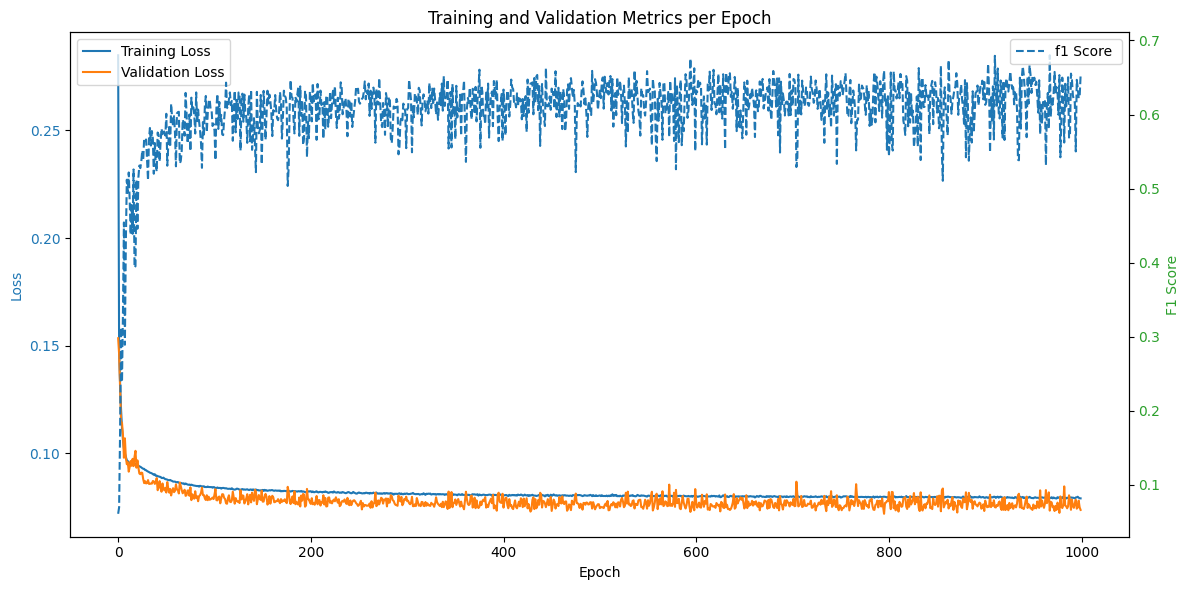

In [18]:
model_name ="_ResNET18_Wheat_"  
spec_dims = x_cal.shape[1]
LR = 0.001
num_epochs = 1000
save_interval = 10
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = ResNet18_1D(mean = mean,std = std, out_dims=30) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.BCEWithLogitsLoss(reduction='mean')
criterion_test = nn.BCEWithLogitsLoss(reduction='mean')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval, classification = True)

In [15]:
model_name ="_ViT_1D_wheat_"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 1000
save_interval = 10
data_path ="/home/metz/deepchemometrics/Aioly/data/dataset/Wheat_dt/DT_test-1.csv"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = ViT_1D(mean = mean,std = std, seq_len = spec_dims, patch_size = 50, dim_embed = 64, trans_layers = 8, heads = 8, mlp_dim = 64, out_dims =30, dropout=0.5) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.BCEWithLogitsLoss(reduction='mean')
criterion_test = nn.BCEWithLogitsLoss(reduction='mean')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification = True)

ViT_1D(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (n p) -> b n (p c)', p=50)
    (1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=50, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-7): 8 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.5, inplace=False)
          (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=512, out_features=64, bias=True)
            (1): Dropout(p=0.5, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=64

OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacty of 15.74 GiB of which 79.38 MiB is free. Process 258533 has 9.13 GiB memory in use. Including non-PyTorch memory, this process has 6.53 GiB memory in use. Of the allocated memory 5.11 GiB is allocated by PyTorch, and 168.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF